In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp.sepp as sepp
import open_cp.sources.sepp as seppsim
import open_cp
import open_cp.kernels

In [2]:
region = open_cp.RectangularRegion(-50, 50, -50, 50)
background_sampler = seppsim.InhomogeneousPoissonFactors(seppsim.HomogeneousPoisson(rate=5.71),
    seppsim.GaussianSpaceSampler([0,0], [4.5**2,4.5**2], 0))
total_rate = 0.2 * (2 * np.pi * 0.01 * 0.1)
trigger_sampler = seppsim.InhomogeneousPoissonFactors(seppsim.Exponential(exp_rate=0.1, total_rate=total_rate),
    seppsim.GaussianSpaceSampler([0,0], [0.01**2, 0.1**2], 0))
sampler = seppsim.SelfExcitingPointProcess(region, background_sampler, trigger_sampler)

In [3]:
#pts = sampler.sample(0,1500)
pts = sampler.sample(0,500)
pts = pts[:,2000:]
pts.shape

(3, 769)

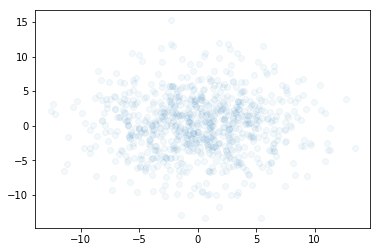

In [4]:
plt.scatter(pts[1], pts[2], alpha=0.05)

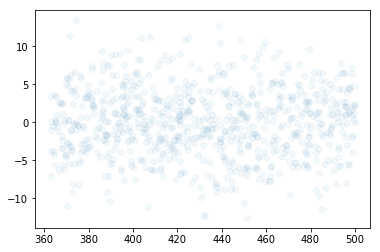

In [5]:
plt.scatter(pts[0], pts[1], alpha=0.05)

In [7]:
decluster = sepp.StocasticDecluster()
decluster.points = pts
decluster.background_kernel_estimator = open_cp.kernels.KthNearestNeighbourGaussianKDE()
decluster.trigger_kernel_estimator = open_cp.kernels.KthNearestNeighbourGaussianKDE()

In [9]:
p = sepp.initial_p_matrix(pts)
p

array([[  1.00000000e+00,   4.97174221e-01,   3.27558218e-01, ...,
          1.92157860e-08,   1.94689418e-08,   1.90755633e-08],
       [  0.00000000e+00,   5.02825779e-01,   3.30197026e-01, ...,
          1.97932854e-08,   1.97108428e-08,   1.93921710e-08],
       [  0.00000000e+00,   0.00000000e+00,   3.42244756e-01, ...,
          2.00204702e-08,   1.96447677e-08,   1.91822983e-08],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.79937342e-02,   1.71600142e-02,   1.69229069e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   1.77682217e-02,   1.74435545e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   1.74859864e-02]])

In [12]:
backs, trigs = sepp.sample_points(pts, p)

In [20]:
ker = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(backs)
ker(np.array([0,0,0]))

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (2,3) and requested shape (3,2,1)

In [10]:
p, bker, tker = decluster.next_iteration(p)